In [22]:
# 전체 코드 구조

# 데이터 전처리

# Random Forest 모델 생성
# TimeSeriesSplit으로 모델 평가
# Shap으로 중요도 분석

# XGBoost 모델 생성
# TimeSeriesSplit으로 모델 평가
# rf, xgb 모델 저장

# Prophet 모델에 맞게 데이터 구성
# Prophet 모델 생성
# TimeSeriesSplit으로 모델 평가


# Prophet 모델에 맞게 데이터 구성
# Prophet 모델 생성
# Prophet 모델 평가


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
import joblib

In [24]:
df = pd.read_csv('../data/processed/final_preprocessed_data.csv', encoding='cp949')
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (6, 4)
df.columns

Index(['날짜', '충전소 수', '충전소 수 증가량', '전기차 주행거리', '주행거리 1분위', '주행거리 2분위',
       '주행거리 3분위', '주행거리 4분위', '경제 상황', '보조금 규모', '1인당 보조금', '목표대수',
       '보조금 지급유무', '유가', '전기차 등록대수', '전기차 등록 변화량', '배터리 가격', '전기차 검색량',
       'Ioniq Electric', 'Kona Electric', 'Kona Electric N', 'Ioniq 5',
       'Ioniq 5 N', 'Ioniq 6', 'Ioniq 6 N', 'Soul EV', 'Niro EV', 'EV6',
       'EV6 N', 'EV9', 'Model S', 'Model X', 'Model 3', 'Model Y', 'SM3 Z.E.',
       'Zoe', 'Bolt EV'],
      dtype='object')

In [25]:
# 날짜 변수 처리
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values(by='날짜').set_index('날짜')

# 시계열 특성 추가
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['months_since_start'] = (df.index.year - df.index.year.min()) * 12 + (df.index.month - df.index.month.min())


# 이동 평균 변수
window = 3
ma_features = [ '유가', '경제 상황',]
for col in ma_features:
        df[f'{col}_MA{window}'] = df[col].rolling(window=window).mean()

# 시차 변수
lag = 3
lag_features = ['충전소 수', '배터리 가격', '유가_MA3', '경제 상황_MA3','전기차 검색량', '전기차 주행거리','충전소 수 증가량']
for col in lag_features:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# 시차 변수에 차량 출시 이벤트 플래그 추가
lag_features = ['Ioniq Electric','Kona Electric','Kona Electric N','Ioniq 5','Ioniq 5 N'
                ,'Ioniq 6','Ioniq 6 N','Soul EV','Niro EV','EV6','EV6 N'
                ,'EV9','Model S','Model X','Model 3','Model Y','SM3 Z.E.','Zoe','Bolt EV']
for col in lag_features:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

In [26]:
original_features = ['보조금 지급유무', '1인당 보조금' ,'목표대수']
time_features = ['year', 'month', 'quarter', 'months_since_start']
derived_featues = [ '배터리 가격_lag3', '유가_MA3_lag3', '경제 상황_MA3_lag3','전기차 검색량_lag3', '전기차 주행거리_lag3','충전소 수_lag3','충전소 수 증가량_lag3']
# 차량 출시 이벤트 플래그 , 영향도에 따라 추가/ 제거
event_flag = [
    # 'Ioniq Electric_lag3',
    # 'Kona Electric_lag3',
    # 'Kona Electric N_lag3',
    'Ioniq 5_lag3',
    # 'Ioniq 5 N_lag3',
    # 'Ioniq 6_lag3',
    # 'Ioniq 6 N_lag3',
    # 'Soul EV_lag3',
    # 'Niro EV_lag3',
    # 'EV6_lag3',
    # 'EV6 N_lag3',
    # 'EV9_lag3',
    # 'Model S_lag3',
    # 'Model X_lag3',
    # 'Model 3_lag3',
    # 'Model Y_lag3',
    # 'SM3 Z.E._lag3',
    # 'Zoe_lag3',
    # 'Bolt EV_lag3'
    ]

TARGET = '전기차 등록 변화량'

data = df[time_features + original_features + derived_featues 
        + event_flag 
        + [TARGET]]

data.dropna(inplace=True)

X = data.drop(columns=TARGET)
y = data[TARGET]

X.to_csv("../data/processed/X_input.csv", index=False, encoding="cp949")

data.head(10)

C:\Users\junjo\AppData\Local\Temp\ipykernel_17988\2465468516.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,year,month,quarter,months_since_start,보조금 지급유무,1인당 보조금,목표대수,배터리 가격_lag3,유가_MA3_lag3,경제 상황_MA3_lag3,전기차 검색량_lag3,전기차 주행거리_lag3,충전소 수_lag3,충전소 수 증가량_lag3,Ioniq 5_lag3,전기차 등록 변화량
날짜,,,,,,,,,,,,,,,,
2015-06-01,2015.0,6.0,2.0,5.0,1.0,2009.8,3000.0,448.0,48.542282,89.333333,10.0,129.333333,3.0,1.0,0.0,390.0
2015-07-01,2015.0,7.0,3.0,6.0,1.0,2009.8,3000.0,448.0,50.953568,90.333333,9.0,129.333333,4.0,1.0,0.0,205.0
2015-08-01,2015.0,8.0,3.0,7.0,1.0,2009.8,3000.0,448.0,53.847164,91.666667,8.0,129.333333,5.0,1.0,0.0,265.0
2015-09-01,2015.0,9.0,3.0,8.0,1.0,2009.8,3000.0,448.0,57.845801,91.666667,8.0,129.333333,6.0,1.0,0.0,299.0
2015-10-01,2015.0,10.0,4.0,9.0,1.0,2009.8,3000.0,448.0,56.661818,90.666667,7.0,129.333333,7.0,1.0,0.0,129.0
2015-11-01,2015.0,11.0,4.0,10.0,1.0,2009.8,3000.0,448.0,51.196025,89.666667,6.0,129.333333,8.0,1.0,0.0,115.0
2015-12-01,2015.0,12.0,4.0,11.0,1.0,2009.8,3000.0,448.0,46.416017,90.000000,9.0,129.333333,9.0,1.0,0.0,95.0
2016-01-01,2016.0,1.0,1.0,12.0,0.0,1808.5,5700.0,448.0,44.856926,91.000000,11.0,129.333333,10.0,1.0,0.0,62.0
2016-02-01,2016.0,2.0,1.0,13.0,1.0,1808.5,5700.0,448.0,44.715553,91.666667,10.0,129.333333,11.0,1.0,0.0,62.0


In [27]:
# 그래프 출력함수
def visualize_compare(y_test, y_pred, title):
  plt.figure(figsize=(6, 3))
  plt.plot(y_test.index, y_test.values, label='실제값', marker='o')
  plt.plot(y_test.index, y_pred, label='예측값', marker='x')
  plt.title(title)
  plt.xlabel('날짜')
  plt.ylabel('등록 변화량')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

# 모델 평가 함수
def evaluate_model(r2_scores, mae_scores, mse_scores, mape_scores):
  rmse_scores = [np.sqrt(mse) for mse in mse_scores]
  for i in range(len(r2_scores)):
      print(f"Fold {i+1} - R²: {r2_scores[i]:.4f}, MAE: {mae_scores[i]:.2f}, RMSE: {rmse_scores[i]:.2f}, MAPE: {mape_scores[i]:.2f}")
  print(f"R² 평균: {np.mean(r2_scores):.4f} R² 표준편차: {np.std(r2_scores):.4f}")
  print(f"MAE 평균: {np.mean(mae_scores):.2f} MAE 표준편차: {np.std(mae_scores):.4f}")
  print(f"RMSE 평균: {np.mean(rmse_scores):.2f}")
  print(f"MAPE 평균: {np.mean(mape_scores):.2f}")

# 피처 중요도 시각화 함수
def show_importance(columns, model, title, graph="N"):
  importance = pd.DataFrame({
      '변수': columns,
      '중요도': model.feature_importances_
  }).sort_values(by='중요도', ascending=False)

  print(importance)
  if graph.upper()=='Y':
    # 피처 중요도 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x='중요도', y='변수', data=importance.head(15))
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()


In [28]:
# Random Forest

tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# 하이퍼파라미터 탐색 공간 정의
param_grid = {
    'n_estimators': [50, 100, 200],           
    'max_depth': [3, 5, 10],                 
    'min_samples_split': [2, 4, 6],         
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['sqrt', 'log2', 0.8]    
}

# 모델 객체 정의
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# GridSearchCV 수행
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score (R²): -0.2396280996199993


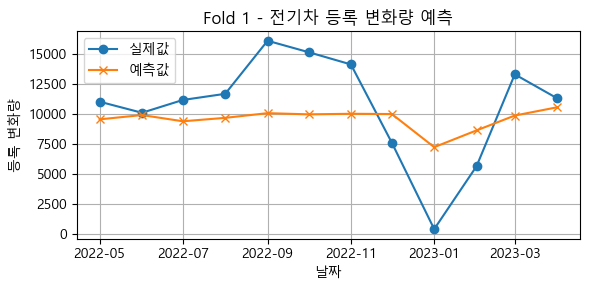

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score (R²): -0.22129861465892361


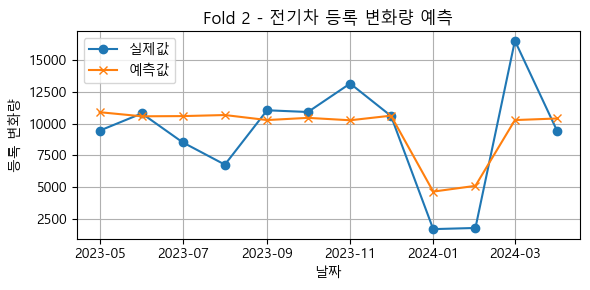

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best score (R²): -0.06298855596376988


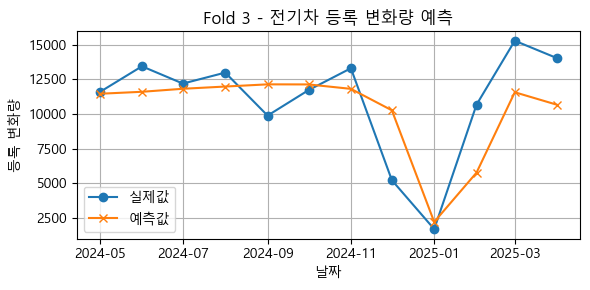


--- 랜덤 포레스트 성능 평가 ---
Fold 1 - R²: 0.2253, MAE: 3105.63, RMSE: 3697.83, MAPE: 1.67
Fold 2 - R²: 0.5426, MAE: 2115.68, RMSE: 2757.18, MAPE: 0.46
Fold 3 - R²: 0.4776, MAE: 2091.25, RMSE: 2697.93, MAPE: 0.24
R² 평균: 0.4152 R² 표준편차: 0.1369
MAE 평균: 2437.52 MAE 표준편차: 472.5313
RMSE 평균: 3050.98
MAPE 평균: 0.79


In [29]:
r2_scores_rf = []
mae_scores_rf = []
mse_scores_rf = []
mape_scores_rf = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]


    grid_search_rf.fit(X_train, y_train)

    print("Best parameters:", grid_search_rf.best_params_)
    print("Best score (R²):", grid_search_rf.best_score_)

    best_rf_model = grid_search_rf.best_estimator_
    best_rf_model.fit(X_train, y_train)

    y_pred = best_rf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    r2_scores_rf.append(r2)
    mae_scores_rf.append(mae)
    mse_scores_rf.append(mse)
    mape_scores_rf.append(mape)
    
    visualize_compare(y_test, y_pred, f'Fold {fold+1} - 전기차 등록 변화량 예측')

print("\n--- 랜덤 포레스트 성능 평가 ---")
evaluate_model(r2_scores_rf, mae_scores_rf, mse_scores_rf, mape_scores_rf)

In [30]:
# 전체 데이터로 학습
grid_search_rf.fit(X, y)

print("Best parameters:", grid_search_rf.best_params_)
print("Best score (R²):", grid_search_rf.best_score_)

# 최적 모델 추출
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X, y)

# 모델 저장
joblib.dump(best_rf_model, '../output/models/best_rf_model.pkl')

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score (R²): 0.46355852060296154


['../output/models/best_rf_model.pkl']

In [31]:
# XGBoost

tscv = TimeSeriesSplit(n_splits=3, test_size=12)

# 하이퍼파라미터 탐색 공간 정의
param_grid = {
    'max_depth': [3, 5, 7],                    
    'learning_rate': [0.01, 0.05, 0.1],     
    'n_estimators': [100, 200, 300],           
    'subsample': [0.6, 0.8, 1.0],        
    'colsample_bytree': [0.6, 0.8, 1.0],     
    'reg_alpha': [0, 0.1, 0.5],                
    'reg_lambda': [0.5, 1, 3]               
}

# 모델 객체 정의
xgb_base = XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1)

# GridSearchCV 실행
grid_search_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 1.0}
Best score (R²): -0.10982579391062013


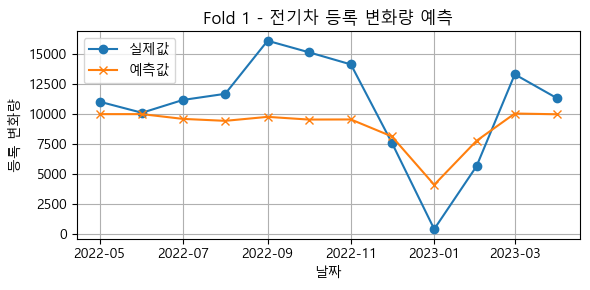

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 3, 'subsample': 1.0}
Best score (R²): -0.044604234170324664


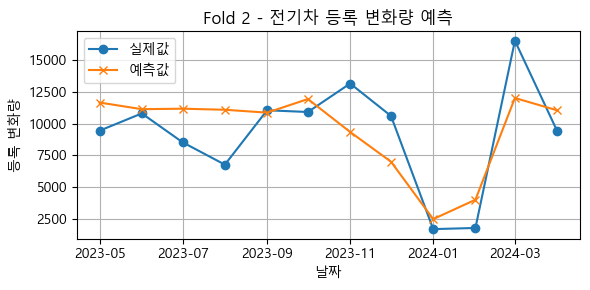

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best score (R²): 0.052514959543904505


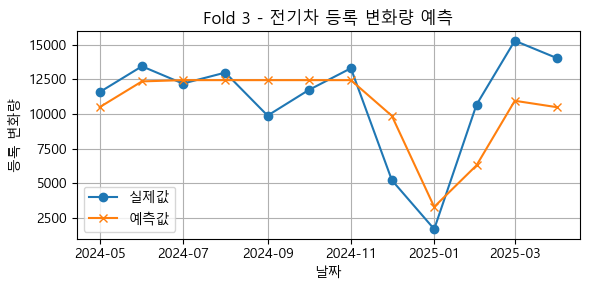


--- XGBOOST 성능 평가 ---
Fold 1 - R²: 0.3720, MAE: 2712.56, RMSE: 3329.22, MAPE: 0.98
Fold 2 - R²: 0.5566, MAE: 2281.63, RMSE: 2714.79, MAPE: 0.35
Fold 3 - R²: 0.4884, MAE: 2138.56, RMSE: 2669.79, MAPE: 0.29
R² 평균: 0.4724 R² 표준편차: 0.0762
MAE 평균: 2377.58 MAE 표준편차: 243.9582
RMSE 평균: 2904.60
MAPE 평균: 0.54


In [32]:
r2_scores_xgb = []
mae_scores_xgb = []
mse_scores_xgb = []
mape_scores_xgb = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index] 
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    grid_search_xgb.fit(X_train, y_train)

    print("Best parameters:", grid_search_xgb.best_params_)
    print("Best score (R²):", grid_search_xgb.best_score_)

    best_xgb_model = grid_search_xgb.best_estimator_

    best_xgb_model.fit(X_train, y_train)

    y_pred = best_xgb_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    r2_scores_xgb.append(r2)
    mae_scores_xgb.append(mae)
    mse_scores_xgb.append(mse)
    mape_scores_xgb.append(mape)
    
    visualize_compare(y_test, y_pred, f'Fold {fold+1} - 전기차 등록 변화량 예측')
    
print("\n--- XGBOOST 성능 평가 ---")
evaluate_model(r2_scores_xgb, mae_scores_xgb, mse_scores_xgb, mape_scores_xgb)

In [33]:
grid_search_xgb.fit(X, y)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best score (R²):", grid_search_xgb.best_score_)

# 최적 모델 추출
best_xgb_model = grid_search_xgb.best_estimator_

best_xgb_model.fit(X, y)

# 모델 저장
joblib.dump(best_xgb_model, '../output/models/best_xgb_model.pkl')


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 1.0}
Best score (R²): 0.6468347221016639


['../output/models/best_xgb_model.pkl']

In [34]:
# Prophet
data_pp = df[original_features + time_features + derived_featues 
        + event_flag 
        + [TARGET]].copy()

data_pp['ds'] = data_pp.index
data_pp['y'] = data_pp[TARGET]
data_pp = data_pp.drop(columns=[TARGET,'year', 'month', 'quarter', 'months_since_start'])
data_pp.dropna(inplace=True)

In [35]:
data_pp.columns

Index(['보조금 지급유무', '1인당 보조금', '목표대수', '배터리 가격_lag3', '유가_MA3_lag3',
       '경제 상황_MA3_lag3', '전기차 검색량_lag3', '전기차 주행거리_lag3', '충전소 수_lag3',
       '충전소 수 증가량_lag3', 'Ioniq 5_lag3', 'ds', 'y'],
      dtype='object')

In [36]:
# 연도별 보조금 발표일
subsidy_announcement_dates = {
    2015: '2015-04-01',
    2016: '2016-01-19',
    2017: '2017-02-03',
    2018: '2018-02-01',
    2019: '2019-01-18',
    2020: '2020-01-20',
    2021: '2021-01-21',
    2022: '2022-02-23',
    2023: '2023-02-02',
    2024: '2024-02-20',
    2025: '2025-01-15',
}

# holiday 항목 생성
holiday_rows = []

for year, announce_str in subsidy_announcement_dates.items():
    start = pd.Timestamp(f'{year}-01-01')
    end = pd.to_datetime(announce_str) - pd.Timedelta(days=1)
    
    # 해당년도1월 1일부터 발표 전날까지
    if end >= start:
        date_range = pd.date_range(start, end)
        for day in date_range:
            holiday_rows.append({
                'holiday': 'no_subsidy',
                'ds': day,
                'lower_window': 0,
                'upper_window': 0
            })

# DataFrame 생성
no_subsidy_df = pd.DataFrame(holiday_rows)

def create_model_instance(regressors):
  model_multi = Prophet(
    holidays=no_subsidy_df,
    holidays_prior_scale=20,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05,)
  
  # 외부 변수 등록하는 부분
  for regressor in regressors:
    model_multi.add_regressor(regressor)
  return model_multi

def visualize_compare_pp(merged, title):
    plt.figure(figsize=(10, 5))
    plt.plot(merged['ds'], merged['y'], label='실제값', marker='o')
    plt.plot(merged['ds'], merged['yhat'], label='예측값', marker='x')
    plt.title(title)
    plt.xlabel('날짜')
    plt.ylabel('전기차 등록 변화량')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def calc_contribution(forecast, regressor_names): 
    # 각 회귀 변수의 평균 절대 기여도 계산
    regressor_contribution_ratios = {}
    
    # 전체 예측의 절대값 합계 (분모)
    total_forecast_abs_sum = np.sum(np.abs(forecast['yhat'].values))

    if total_forecast_abs_sum == 0:
        print("경고: 전체 예측의 절대값 합계가 0이므로 기여도 비율을 계산할 수 없습니다.")
    else:
        for reg_name in regressor_names:
            if reg_name in forecast.columns:
                # 각 회귀 변수 기여도의 절대값 합계 (분자)
                regressor_abs_sum = np.sum(np.abs(forecast[reg_name].values))
                # 비율 계산
                regressor_contribution_ratios[reg_name] = (regressor_abs_sum / total_forecast_abs_sum) * 100
            else:
                regressor_contribution_ratios[reg_name] = 0.0


        importance_df_ratio = pd.DataFrame({
            'Feature': regressor_contribution_ratios.keys(),
            'Importance': regressor_contribution_ratios.values()
        }).sort_values(by='Importance', ascending=False)

        return importance_df_ratio

def visualize_contribution(importance_df_ratio):
    # 피처 중요도 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_ratio.head(15))
    plt.title('Top 15 Feature Importances (Prophet)', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

20:09:49 - cmdstanpy - INFO - Chain [1] start processing
20:09:49 - cmdstanpy - INFO - Chain [1] done processing


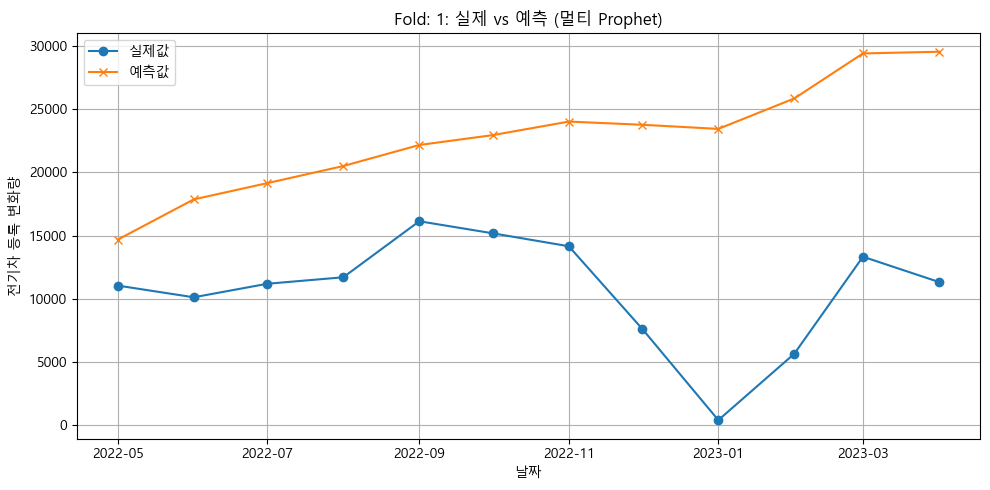

20:09:50 - cmdstanpy - INFO - Chain [1] start processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing


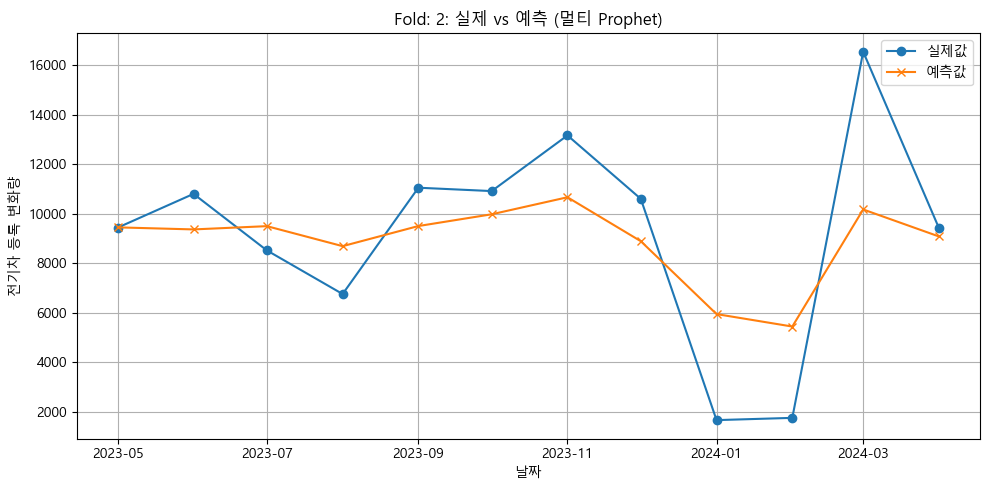

20:09:50 - cmdstanpy - INFO - Chain [1] start processing
20:09:50 - cmdstanpy - INFO - Chain [1] done processing


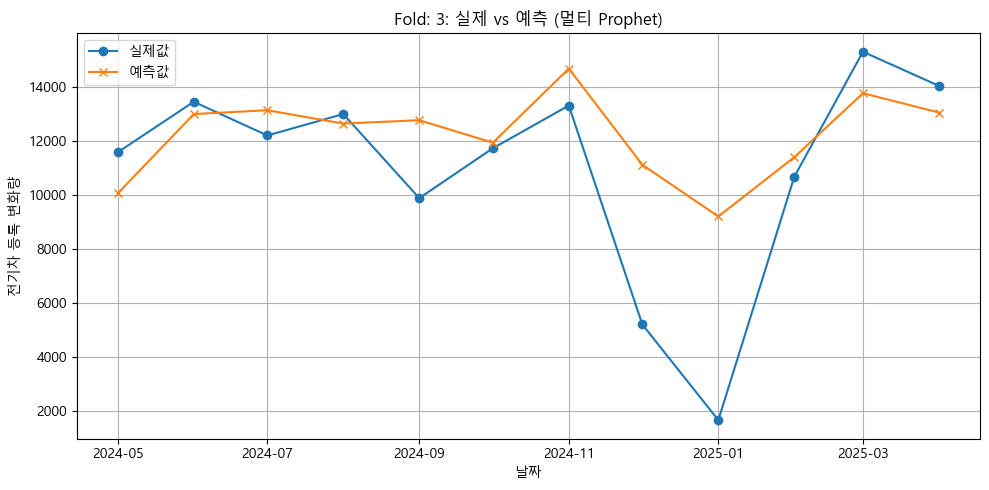


--- 멀티 Prophet 성능 평가 ---
Fold 1 - R²: -9.3897, MAE: 12131.23, RMSE: 13541.78, MAPE: 5.93
Fold 2 - R²: 0.5391, MAE: 2145.26, RMSE: 2767.69, MAPE: 0.52
Fold 3 - R²: 0.3468, MAE: 2033.52, RMSE: 3016.87, MAPE: 0.55
R² 평균: -2.8346 R² 표준편차: 4.6358
MAE 평균: 5436.67 MAE 표준편차: 4733.9880
RMSE 평균: 6442.11
MAPE 평균: 2.33


In [37]:
# 테스트 모델

r2_scores = []
mae_scores = []
mse_scores = []
mape_scores = []

tscv = TimeSeriesSplit(n_splits=3, test_size=12)    

for fold, (train_index, test_index) in enumerate(tscv.split(data_pp)):
    train = data_pp.iloc[train_index]
    test = data_pp.iloc[test_index]

    model_multi = create_model_instance(data_pp.columns.drop(['ds', 'y']))
    model_multi.fit(train)
    
    regressor_names = list(model_multi.extra_regressors.keys())

    # 학습 데이터 기반 예측
    future_train = train.drop(columns='y')
    forecast_train = model_multi.predict(future_train)

    # 테스트 데이터 기반 예측
    future_test = test.drop(columns='y')
    forecast_test = model_multi.predict(future_test)

    # 테스트 데이터 기반 예측 결과와 실제값 병합 (ds 기준)
    merged = forecast_test[['ds', 'yhat']].merge(test[['ds', 'y']], on='ds', how='inner')

    r2 = r2_score(merged['y'], merged['yhat'])
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    mse = mean_squared_error(merged['y'], merged['yhat'])
    mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])

    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    mape_scores.append(mape)

    visualize_compare_pp(merged, title=f"Fold: {fold + 1}: 실제 vs 예측 (멀티 Prophet)")
    
    # print("\n [학습 데이터로 중요도 계산] \n")
    # importance = calc_contribution(forecast_train, regressor_names)
    # print(importance)
    # #visualize_contribution(importance)

    # print("\n [테스트 데이터로 중요도 계산] \n")
    # importance = calc_contribution(forecast_test, regressor_names)
    # print(importance)
    # #visualize_contribution(importance)

print("\n--- 멀티 Prophet 성능 평가 ---")
evaluate_model(r2_scores, mae_scores, mse_scores, mape_scores)

In [38]:
# 전체 데이터 학습한 모델

model_multi = create_model_instance(data_pp.columns.drop(['ds', 'y']))
model_multi.fit(data_pp)

future = data_pp.drop(columns='y')
forecast = model_multi.predict(future)

# 예측 결과와 실제값 병합 (ds 기준)
merged = forecast[['ds', 'yhat']].merge(data_pp[['ds', 'y']], on='ds', how='inner')

20:09:51 - cmdstanpy - INFO - Chain [1] start processing
20:09:51 - cmdstanpy - INFO - Chain [1] done processing


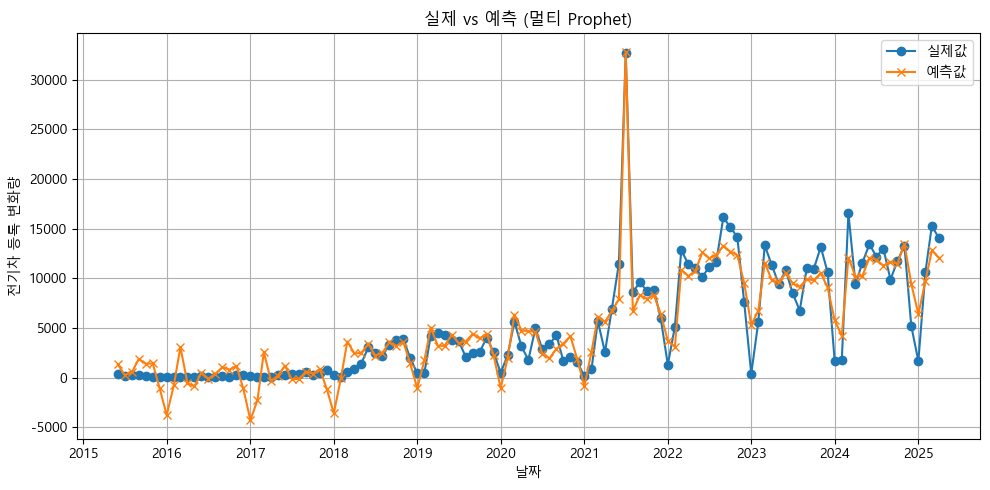

           Feature  Importance
0         보조금 지급유무   54.011490
3      배터리 가격_lag3   26.531737
4      유가_MA3_lag3   20.171443
1          1인당 보조금   17.660649
6     전기차 검색량_lag3   13.471129
2             목표대수    7.656619
10    Ioniq 5_lag3    4.015953
9   충전소 수 증가량_lag3    3.340764
8       충전소 수_lag3    2.020749
5   경제 상황_MA3_lag3    1.921569
7    전기차 주행거리_lag3    1.667373


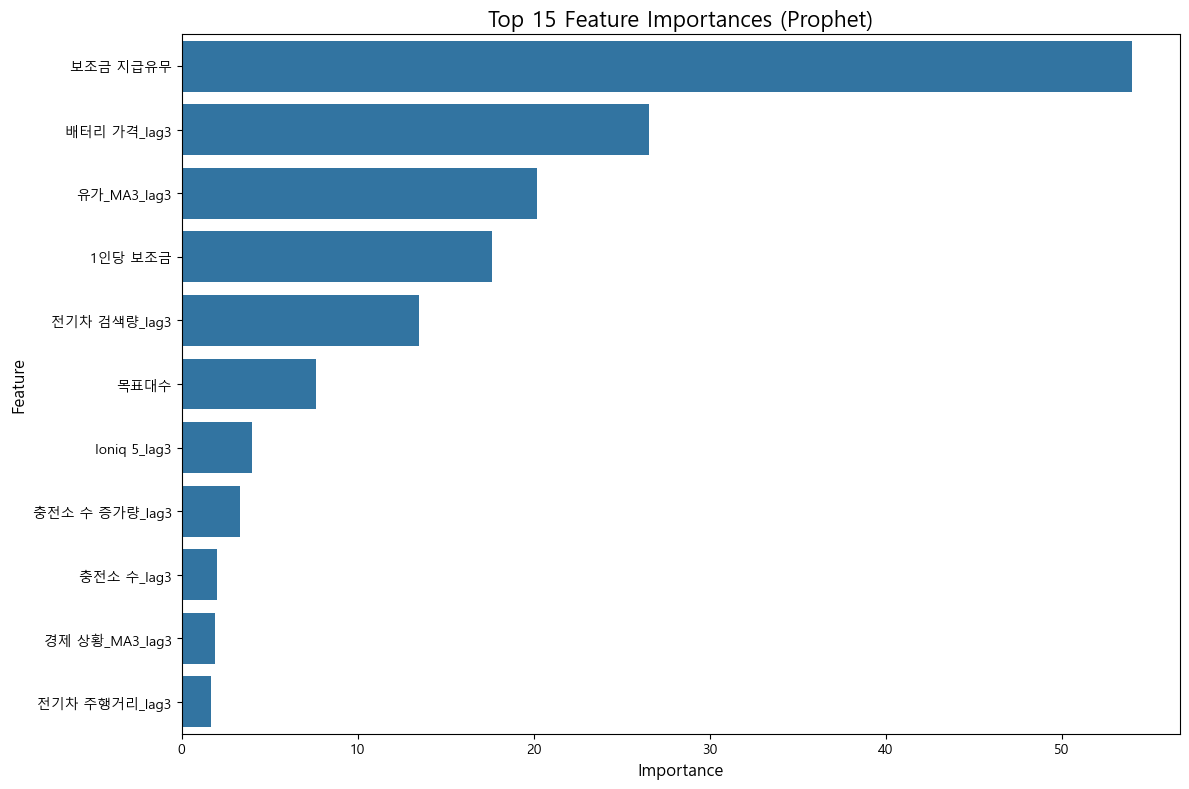

In [39]:
# 학습 데이터로 예측 및 변수 중요도 계산

regressor_names = list(model_multi.extra_regressors.keys())

visualize_compare_pp(merged, title="실제 vs 예측 (멀티 Prophet)")

importance = calc_contribution(forecast, regressor_names)
print(importance)
visualize_contribution(importance)

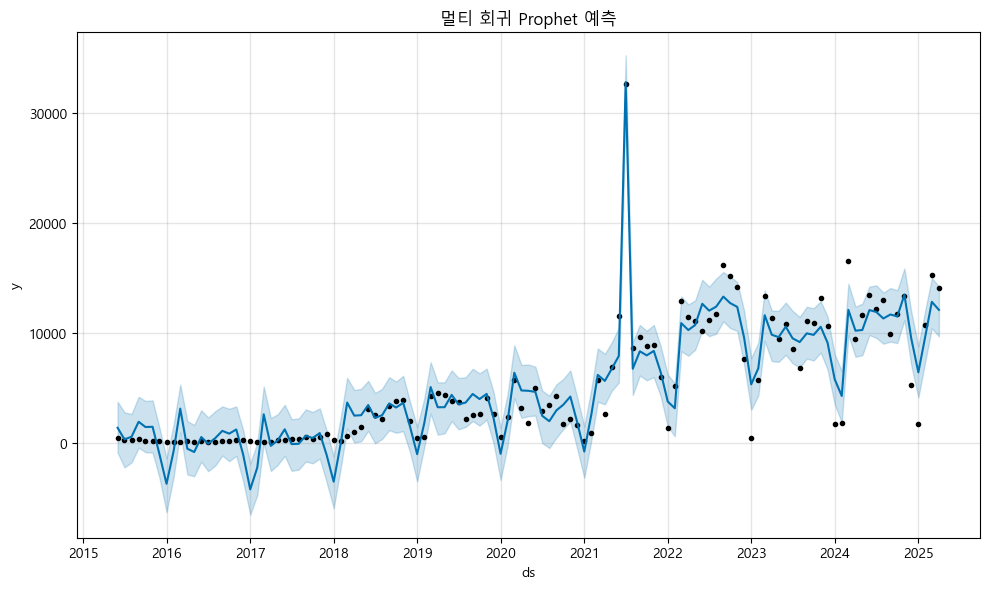

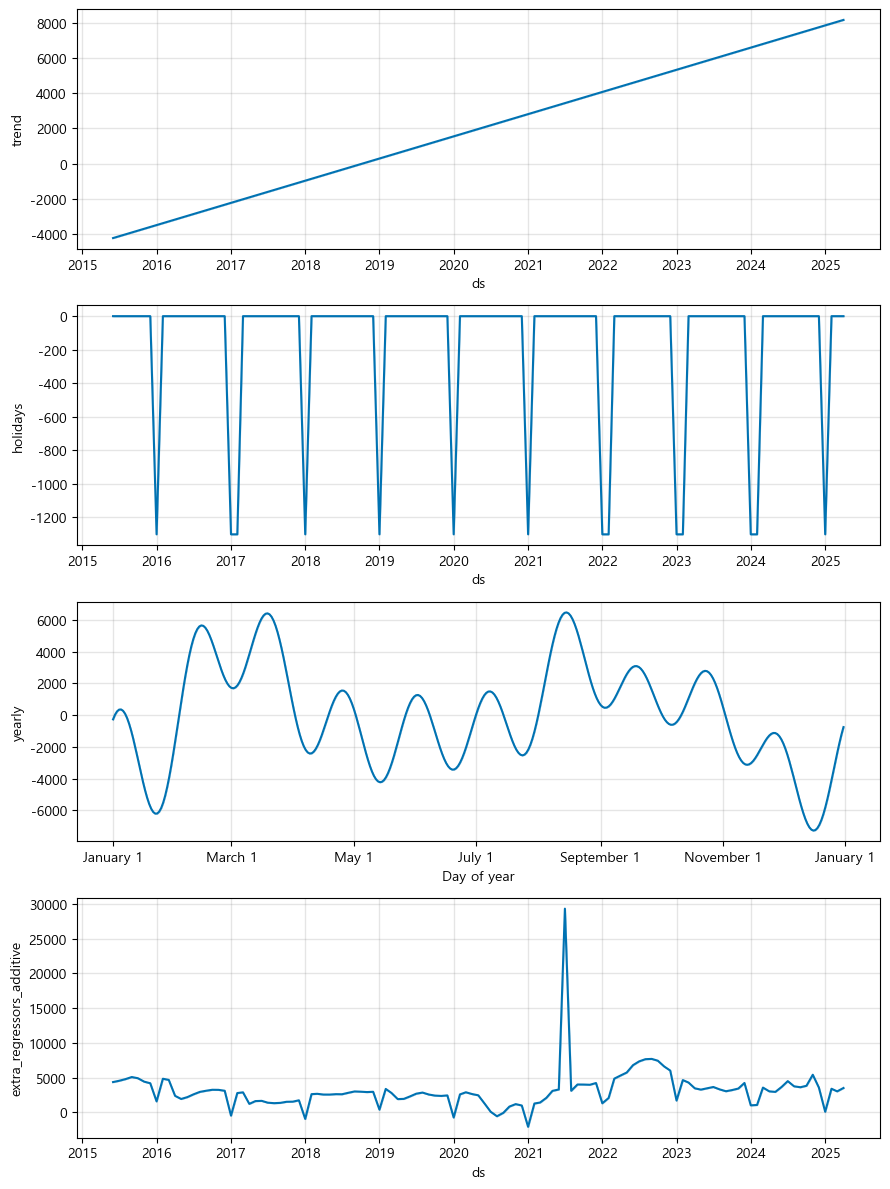

In [40]:
# 예측 그래프
model_multi.plot(forecast)
plt.title('멀티 회귀 Prophet 예측')
plt.tight_layout()
plt.show()

# 구성 요소 (trend, yearly 등)
model_multi.plot_components(forecast)
plt.tight_layout()
plt.show()

C:\Users\junjo\AppData\Local\Temp\ipykernel_17988\2252742421.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


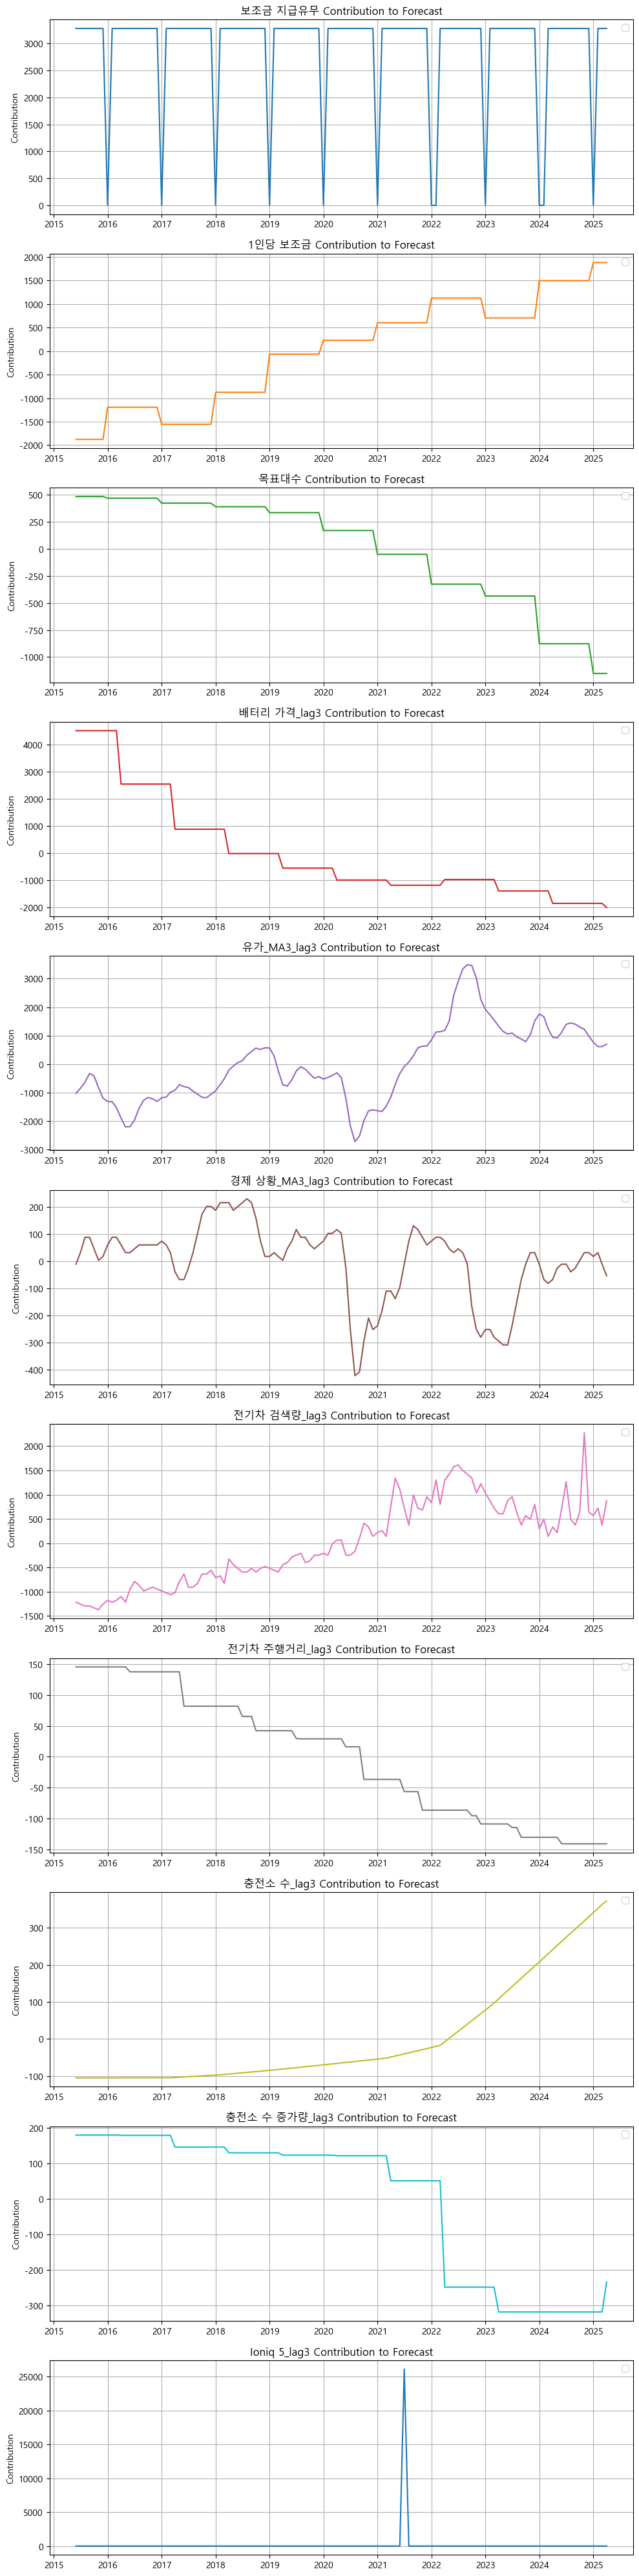

In [41]:
# 외부 회귀 변수 시계열 기여도 개별 시각화
regressor_names = list(model_multi.extra_regressors.keys())

plt.figure(figsize=(10, 40))

for i, reg_name in enumerate(regressor_names):
    if reg_name in forecast.columns:
        plt.subplot(len(regressor_names), 1, i + 1)
        plt.plot(forecast['ds'], forecast[reg_name], color=f'C{i}')
        plt.title(f'{reg_name} Contribution to Forecast')
        plt.ylabel('Contribution')
        plt.grid(True)
        plt.legend()
    else:
        print(f"Warning: '{reg_name}' column not found in forecast. This regressor's contribution cannot be plotted individually.")

plt.tight_layout()
plt.show()